In [ ]:
pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.colors as colors

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

sns.set()

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
file_path='/content/drive/MyDrive/finalproject'
os.chdir(file_path)

Mounted at /content/drive


In [ ]:
sample_df = pd.read_csv('california_2006_2021_sampled_data.csv')
print(sample_df)

<ipython-input-4-7e2d3c208645>:1: DtypeWarning: Columns (11,25,37) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pd.read_csv('california_2006_2021_sampled_data.csv')


         case_id  jurisdiction officer_id reporting_district       chp_shift  \
0       90385802        9655.0     017263                NaN  0600 thru 1359   
1       90528328        9645.0     017529                NaN  1400 thru 2159   
2       91484778        9450.0     021270                NaN  2200 thru 0559   
3       90561090        9285.0     018522                NaN  1400 thru 2159   
4       90596691        9220.0      15060                NaN  1400 thru 2159   
...          ...           ...        ...                ...             ...   
267809  91005015        9855.0     020046                NaN  2200 thru 0559   
267810   5260261        9340.0      20197                NaN  1400 thru 2159   
267811  90692306        9525.0     021967                NaN  1400 thru 2159   
267812  91006506        9340.0     022204                NaN  0600 thru 1359   
267813  90622553        9550.0     020551                NaN  1400 thru 2159   

              population  county_city_l

In [ ]:
sample_df.shape

(267814, 132)

In [ ]:
columns = ['beat_type', 'intersection', 'weather_1', 'location_type', 'ramp_intersection', 'side_of_highway', 'primary_collision_factor', 'motor_vehicle_involved_with', 'road_surface',
           'road_condition_1', 'lighting', 'chp_road_type', 'statewide_vehicle_type_at_fault', 'primary_ramp', 'crash_time', 'crash_timestamp', 'days_conditions', 'collision_severity',
           'jurisdiction', 'reporting_district', 'population', 'state_highway_indicator', 'pedestrian_action', 'control_device', 'secondary_ramp', 'chp_vehicle_type_at_fault', 'special_condition', 'pcf_violation_category',
'type_of_collision', 'bicycle_collision', 'motorcycle_collision', 'party_count']

subset_df = sample_df[columns]

subset_df = subset_df.dropna(subset=['collision_severity'])
subset_df = subset_df.dropna(subset=['type_of_collision'])
coll_type_barchart = subset_df
subset_df = subset_df.dropna(subset=['motorcycle_collision'])
motorcycle_barchart = subset_df

original_collision_labels = subset_df['collision_severity'].unique()

label_encoder = LabelEncoder()

subset_df = subset_df.fillna('Unknown')

mappings = {}

# Convert and encode categorical data to numerical
for col in subset_df.columns:
    if subset_df[col].dtype == 'object':
        subset_df[col] = label_encoder.fit_transform(subset_df[col].astype(str))
        mappings[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

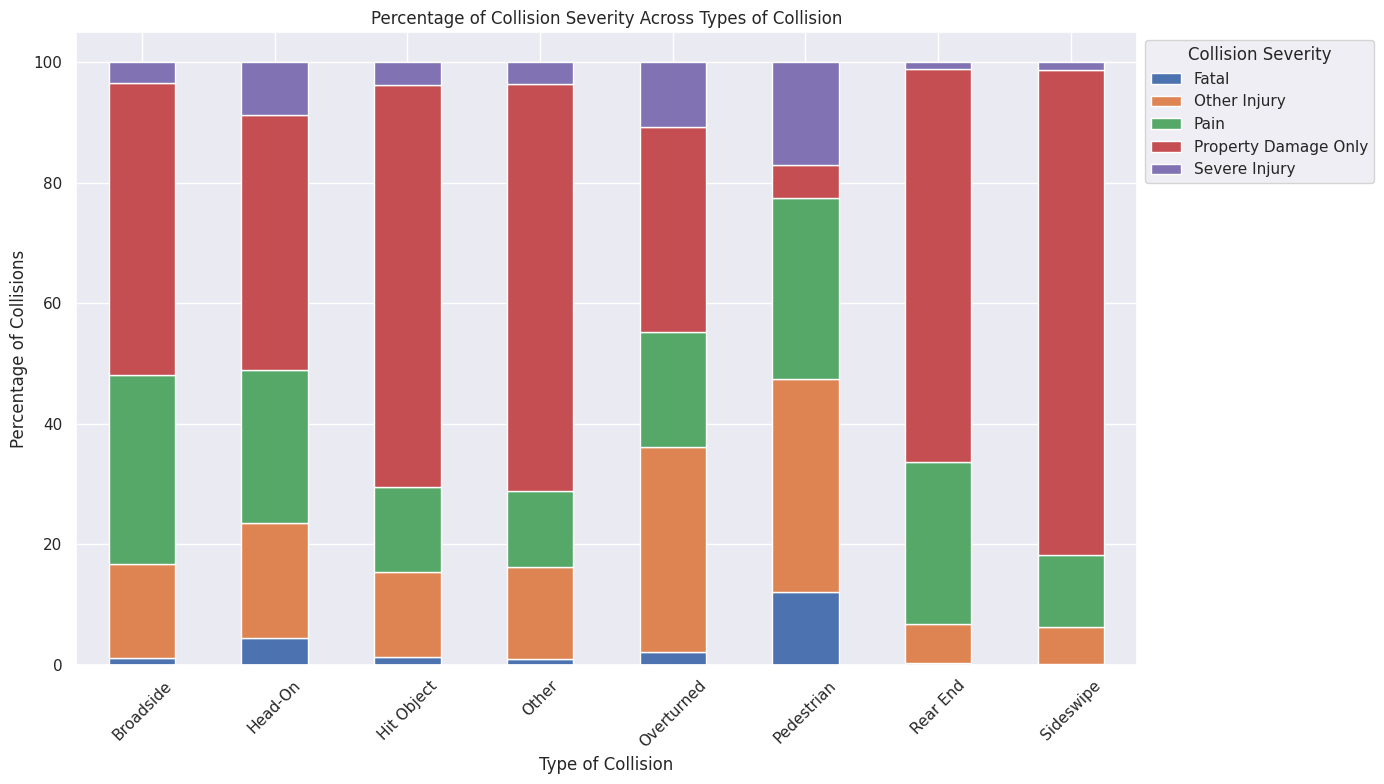

In [ ]:
grouped_collision_type = coll_type_barchart.groupby(['type_of_collision', 'collision_severity']).size().unstack(fill_value=0)

grouped_collision_type_percentage = grouped_collision_type.div(grouped_collision_type.sum(axis=1), axis=0) * 100

original_type_labels = ['Broadside', 'Head-On', 'Hit Object', 'Other', 'Overturned', 'Pedestrian', 'Rear End', 'Sideswipe']

grouped_collision_type_percentage.plot(kind='bar', stacked=True, figsize=(14, 8))

plt.title('Percentage of Collision Severity Across Types of Collision')
plt.xlabel('Type of Collision')
plt.ylabel('Percentage of Collisions')
plt.xticks(ticks=range(len(original_type_labels)), labels=original_type_labels, rotation=45)
plt.legend(title='Collision Severity', labels=['Fatal', 'Other Injury', 'Pain', 'Property Damage Only', 'Severe Injury'], loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

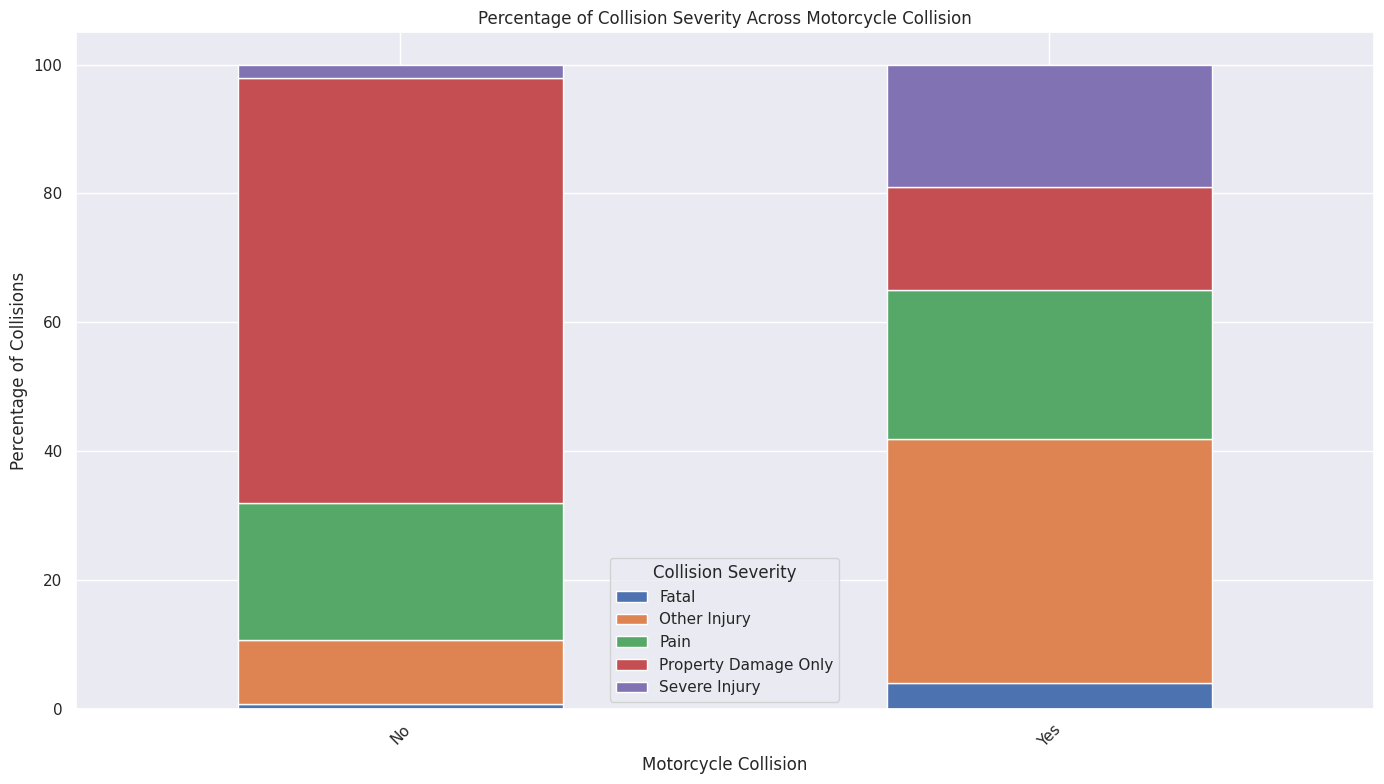

In [ ]:
subset_df = subset_df.dropna(subset=['motorcycle_collision'])
grouped_motorcycle = motorcycle_barchart.groupby(['motorcycle_collision', 'collision_severity']).size().unstack(fill_value=0)

grouped_motorcycle_percentage = grouped_motorcycle.div(grouped_motorcycle.sum(axis=1), axis=0) * 100

original_type_labelss = ['No', 'Yes']

grouped_motorcycle_percentage.plot(kind='bar', stacked=True, figsize=(14, 8))

plt.title('Percentage of Collision Severity Across Motorcycle Collision')
plt.xlabel('Motorcycle Collision')
plt.ylabel('Percentage of Collisions')
plt.xticks(ticks=range(len(original_type_labelss)), labels=original_type_labelss, rotation=45)  #'Fatal', 'Other Injury', 'Pain', 'Property Damage Only', 'Severe Injury'
plt.legend(title='Collision Severity', labels=['Fatal', 'Other Injury', 'Pain', 'Property Damage Only', 'Severe Injury'])
plt.tight_layout()
plt.show()

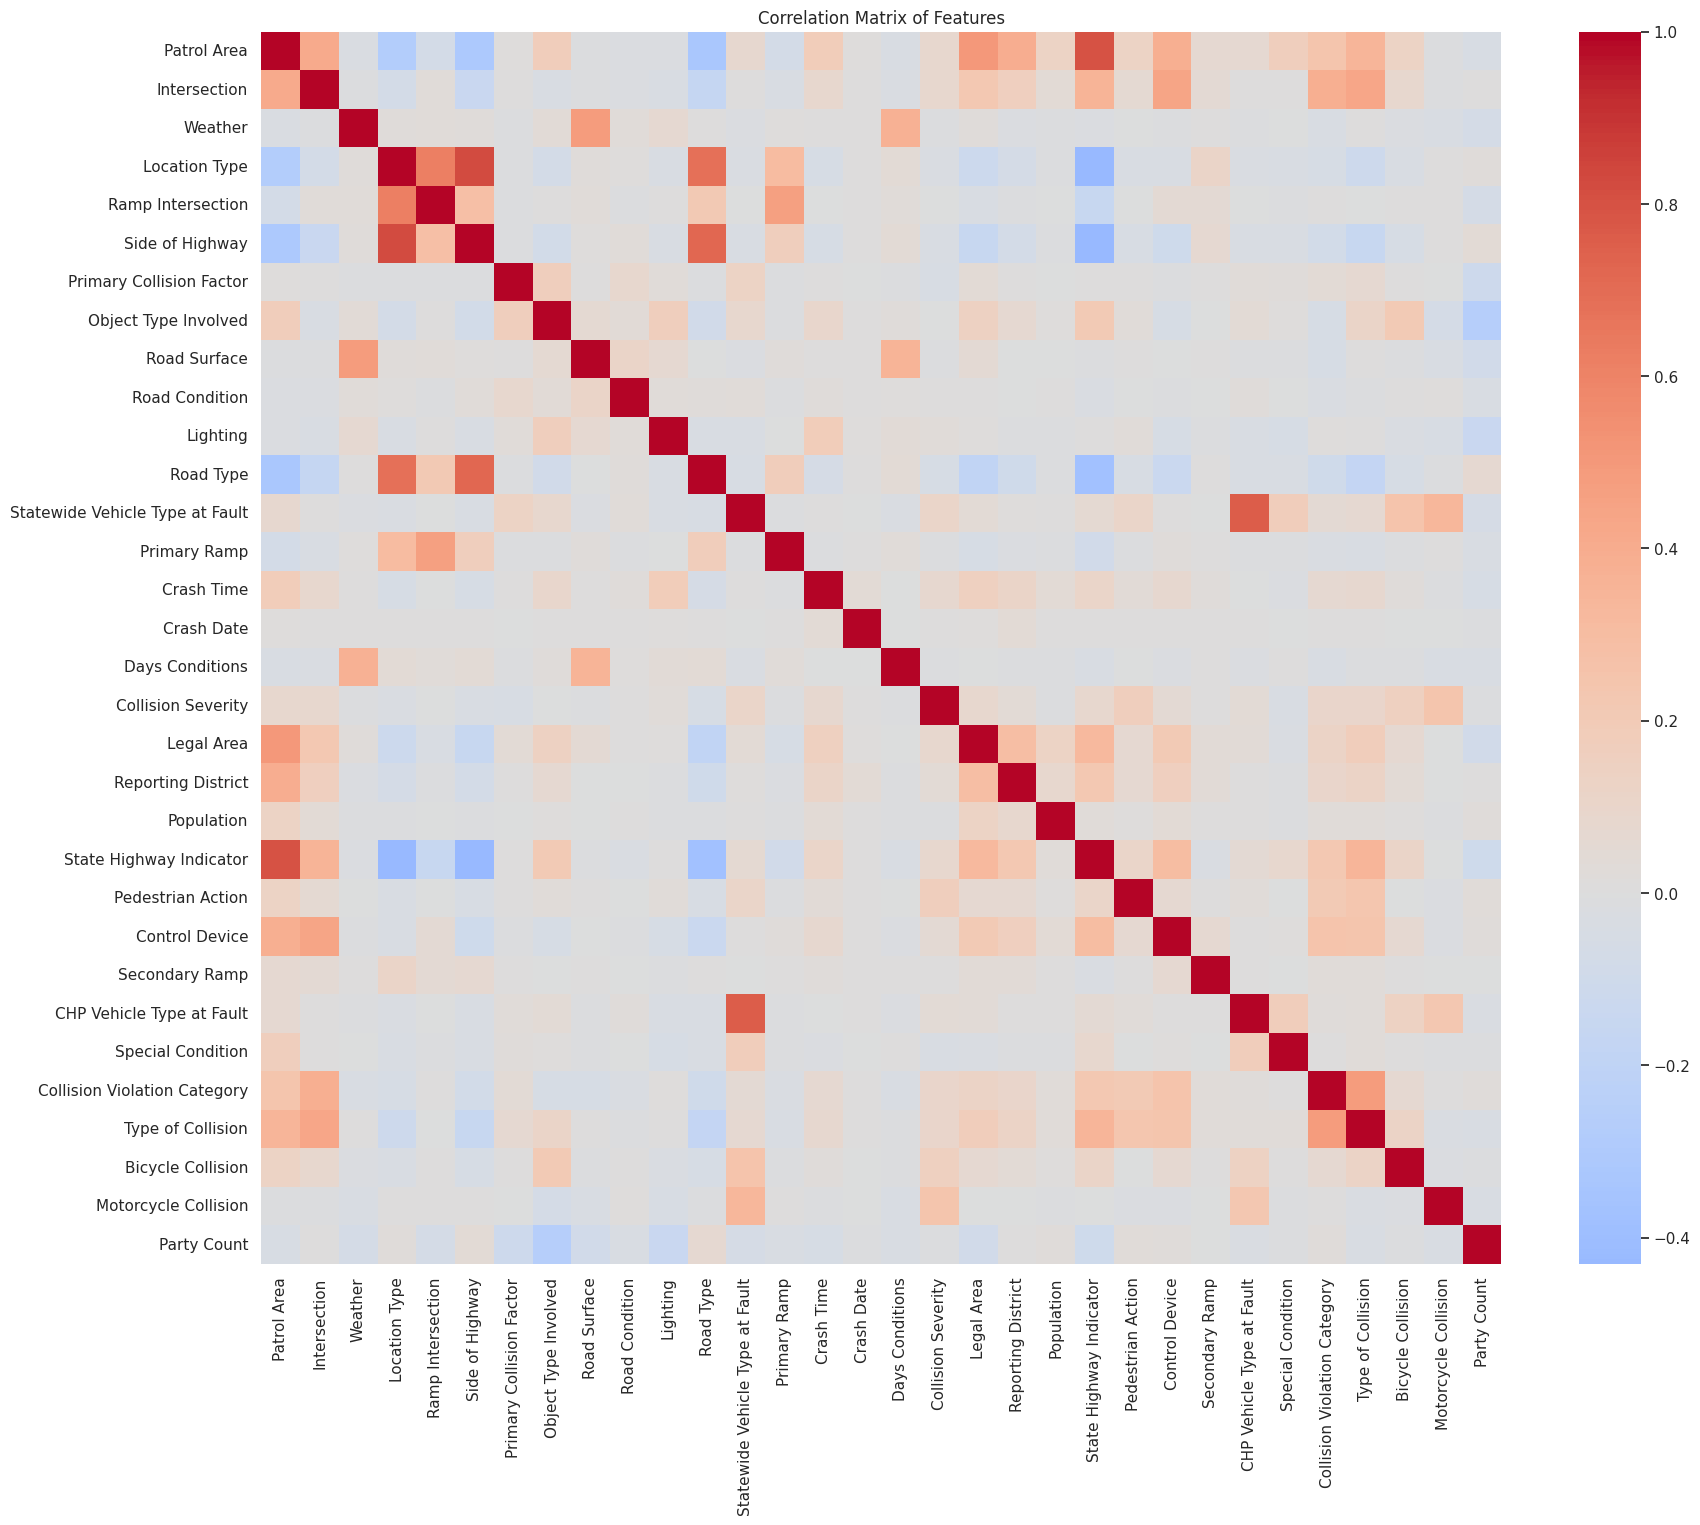

In [ ]:
# Encode categories to an integer
subset_df_encoded = subset_df.apply(lambda x: pd.factorize(x)[0])

corr_matrix = subset_df_encoded.corr()

x_labels = ['Patrol Area', 'Intersection', 'Weather', 'Location Type', 'Ramp Intersection', 'Side of Highway', 'Primary Collision Factor', 'Object Type Involved', 'Road Surface',
           'Road Condition', 'Lighting', 'Road Type', 'Statewide Vehicle Type at Fault', 'Primary Ramp', 'Crash Time', 'Crash Date', 'Days Conditions', 'Collision Severity',
           'Legal Area', 'Reporting District', 'Population', 'State Highway Indicator', 'Pedestrian Action', 'Control Device', 'Secondary Ramp', 'CHP Vehicle Type at Fault', 'Special Condition', 'Collision Violation Category',
'Type of Collision', 'Bicycle Collision', 'Motorcycle Collision', 'Party Count']
y_labels = ['Patrol Area', 'Intersection', 'Weather', 'Location Type', 'Ramp Intersection', 'Side of Highway', 'Primary Collision Factor', 'Object Type Involved', 'Road Surface',
           'Road Condition', 'Lighting', 'Road Type', 'Statewide Vehicle Type at Fault', 'Primary Ramp', 'Crash Time', 'Crash Date', 'Days Conditions', 'Collision Severity',
           'Legal Area', 'Reporting District', 'Population', 'State Highway Indicator', 'Pedestrian Action', 'Control Device', 'Secondary Ramp', 'CHP Vehicle Type at Fault', 'Special Condition', 'Collision Violation Category',
'Type of Collision', 'Bicycle Collision', 'Motorcycle Collision', 'Party Count']


ticks = np.arange(len(x_labels)) + 0.5
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.xticks(ticks = ticks, rotation=90, labels = x_labels)
plt.yticks(ticks = ticks, rotation=0, labels = y_labels)
plt.show()

In [ ]:
X = subset_df.drop('collision_severity', axis=1)
y = subset_df['collision_severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)


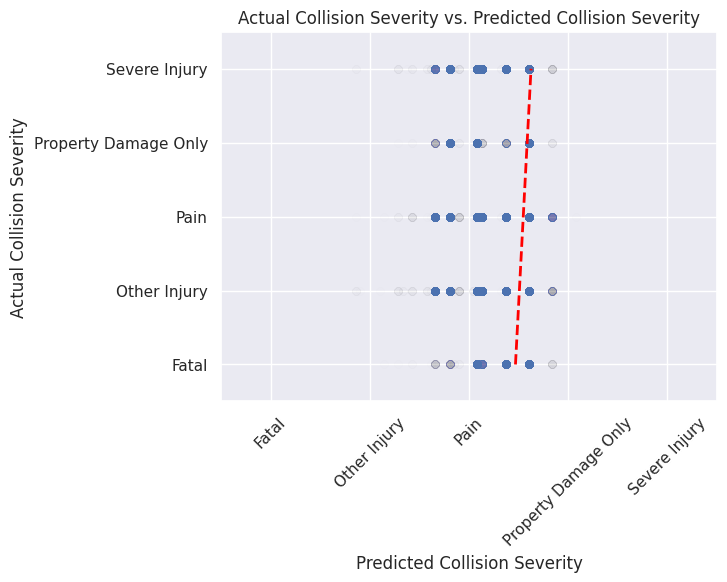

In [ ]:
lm = LinearRegression().fit(subset_df[['pedestrian_action', 'bicycle_collision', 'motorcycle_collision']], y)

y_preds = lm.predict(subset_df[['pedestrian_action', 'bicycle_collision', 'motorcycle_collision']])

plt.xlim(-0.5, 4.5)
plt.ylim(-0.5, 4.5)
plt.scatter(y_preds,y, alpha=0.005)


original_collision_labels = ['Fatal', 'Other Injury', 'Pain', 'Property Damage Only', 'Severe Injury']
plt.xticks(np.arange(len(original_collision_labels)), original_collision_labels, rotation=45)
plt.yticks(np.arange(len(original_collision_labels)), original_collision_labels)
plt.title('Actual Collision Severity vs. Predicted Collision Severity')
plt.xlabel('Predicted Collision Severity')
plt.ylabel('Actual Collision Severity')

reg_line = LinearRegression().fit(y.values.reshape(-1, 1), y_preds)
line_x = np.linspace(y.min(), y.max(), 100)
line_y = reg_line.predict(line_x.reshape(-1, 1))

plt.plot( line_y, line_x,color='red', linewidth=2, linestyle='--')
plt.show()


Accuracy: 0.6672593202575235


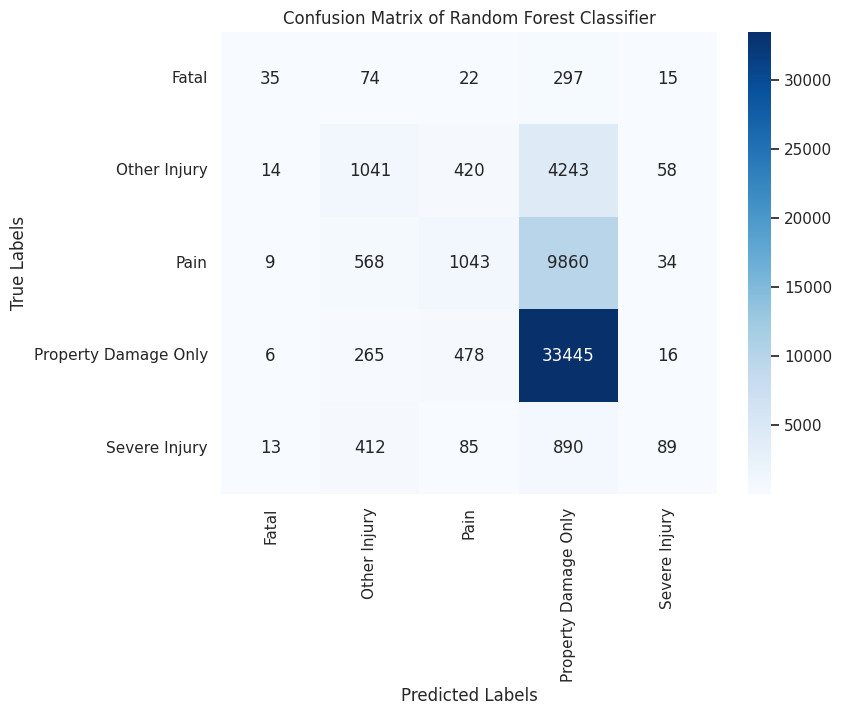

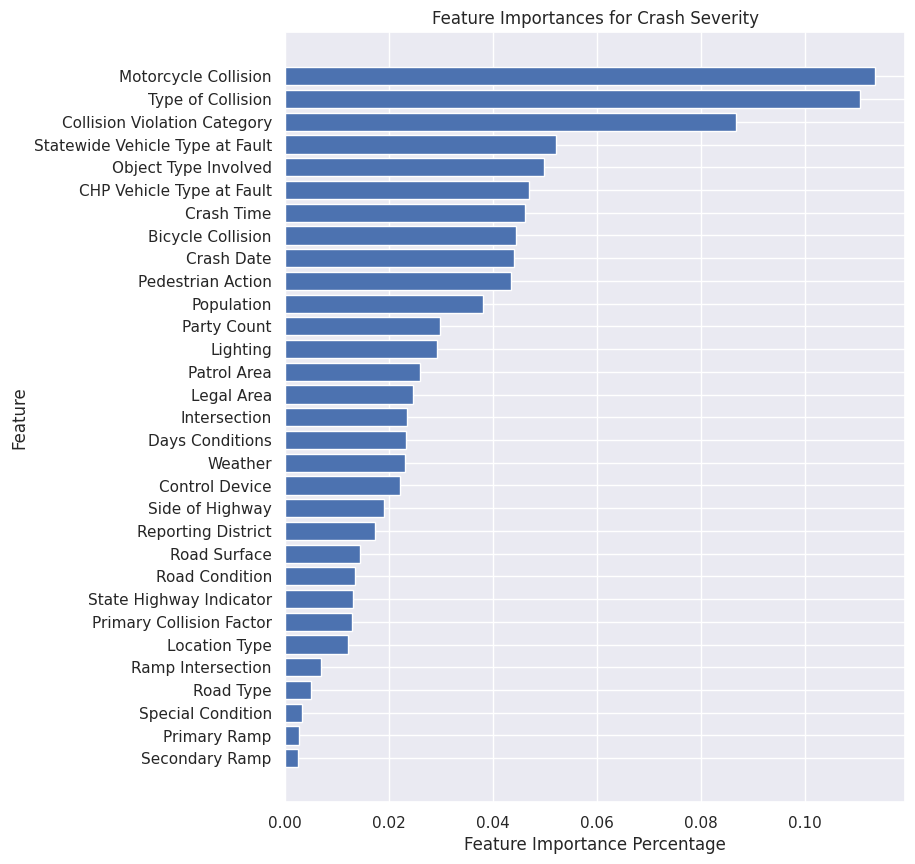

In [ ]:
# Used these parameters for GridSearch
'''
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}
'''

# Binned continuous variables
for col in X_train.columns:
    if X_train[col].dtype != 'object':
        X_train[col], bins = pd.cut(X_train[col], bins=5, labels=False, retbins=True, duplicates='drop')
        X_test[col] = pd.cut(X_test[col], bins=bins, labels=False, duplicates='drop')


        X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
        X_test[col] = X_test[col].fillna(X_test[col].mode()[0])

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=10)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_classifier.fit(X_train, y_train)

rf_predictions = rf_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, rf_predictions))
# Used grid search to find best hyperparameters
# Too computationally expensive to run every time
'''
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
'''
# Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}




cm = confusion_matrix(y_test, rf_predictions)

original_collision_labels = ['Fatal', 'Other Injury', 'Pain', 'Property Damage Only', 'Severe Injury']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=original_collision_labels,
            yticklabels=original_collision_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of Random Forest Classifier')
plt.show()


y_labels = ['Patrol Area', 'Intersection', 'Weather', 'Location Type', 'Ramp Intersection', 'Side of Highway', 'Primary Collision Factor', 'Object Type Involved', 'Road Surface',
           'Road Condition', 'Lighting', 'Road Type', 'Statewide Vehicle Type at Fault', 'Primary Ramp', 'Crash Time', 'Crash Date', 'Days Conditions',
           'Legal Area', 'Reporting District', 'Population', 'State Highway Indicator', 'Pedestrian Action', 'Control Device', 'Secondary Ramp', 'CHP Vehicle Type at Fault', 'Special Condition', 'Collision Violation Category',
'Type of Collision', 'Bicycle Collision', 'Motorcycle Collision', 'Party Count']
ticks = np.arange(len(y_labels))
# Retrieve feature importance scores from the trained model
feature_importances = rf_classifier.feature_importances_
plt.figure(figsize=(8, 10))
sorted_index = np.argsort(rf_classifier.feature_importances_)
plt.barh(np.array(y_labels)[sorted_index], rf_classifier.feature_importances_[sorted_index])  # Feature importances
plt.xlabel("Feature Importance Percentage")
plt.ylabel("Feature")
plt.yticks(ticks = ticks, rotation=0, labels = np.array(y_labels)[sorted_index])
plt.title("Feature Importances for Crash Severity")
plt.show()


In [ ]:
classification_rep = classification_report(y_test, rf_predictions)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.08      0.13       443
           1       0.44      0.18      0.26      5776
           2       0.51      0.09      0.15     11514
           3       0.69      0.98      0.81     34210
           4       0.42      0.06      0.10      1489

    accuracy                           0.67     53432
   macro avg       0.50      0.28      0.29     53432
weighted avg       0.61      0.67      0.58     53432



In [ ]:
def weighted_accuracy_score(y_true, y_pred, class_weights):
    cm = confusion_matrix(y_true, y_pred)
    total_weighted_correct = 0
    total_weight = 0

    for i, weight in class_weights.items():
        true_count = np.sum(cm[i, :])
        correct_count = cm[i, i]
        total_weighted_correct += weight * correct_count
        total_weight += weight * true_count

    weighted_accuracy = total_weighted_correct / total_weight
    return weighted_accuracy

class_weights = {
    0: 1.0,  # 'fatal'
    1: 0.25, # 'other injury'
    2: 1.0,  # 'pain'
    3: 1.0,  # 'property damage'
    4: 1.0  # 'severe injury'
}

weighted_acc = weighted_accuracy_score(y_test, rf_predictions, class_weights)
print("Weighted Accuracy:", weighted_acc)

Weighted Accuracy: 0.7102291242362525


In [ ]:
print(np.sqrt(len(X_train)))
neighbors = np.sqrt(len(X_train))
actual_neighbor = int(neighbors)
print(actual_neighbor)
knn = KNeighborsClassifier(actual_neighbor)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, knn_predictions))
#KNN without reducing size

462.3072571353385
462
Accuracy: 0.6575460398263213


In [ ]:
columns = ['beat_type', 'intersection', 'weather_1', 'location_type', 'ramp_intersection', 'side_of_highway', 'primary_collision_factor', 'motor_vehicle_involved_with', 'road_surface',
           'road_condition_1', 'lighting', 'chp_road_type', 'statewide_vehicle_type_at_fault', 'primary_ramp', 'crash_time', 'crash_timestamp', 'days_conditions', 'collision_severity',
           'jurisdiction', 'reporting_district', 'population', 'state_highway_indicator', 'pedestrian_action', 'control_device', 'secondary_ramp', 'chp_vehicle_type_at_fault', 'special_condition', 'pcf_violation_category',
'type_of_collision', 'bicycle_collision', 'motorcycle_collision', 'party_count']
#Selecting columns for KNN
subset_df = sample_df[columns]

subset_df = subset_df.sample(frac=0.01, random_state=333)
#Using small subset of data for visualization purposes

In [ ]:
dependent_feature = 'collision_severity'
#Isolating collision severity

label_mappings = {}
label_encoder = LabelEncoder()
for col in subset_df.columns:
    if subset_df[col].dtype == 'object':
        subset_df[col] = subset_df[col].fillna('Unknown')#Converts missing values to category, so model can process them
        #subset_df[col] = subset_df[col].fillna('unknown')#Accounting for other types of unknown i
        subset_df[col] = label_encoder.fit_transform(subset_df[col].astype(str))#Converts categorical to numerical
#Same label process as before, however, redoing it since it is on a smaller subset of data
        label_mappings[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    elif subset_df[col].dtype in ['int64', 'float64']:
        subset_df[col] = subset_df[col].fillna(subset_df[col].median())
#Replace NaN values with median so that the distribution remains roughly unchanged, essentially adding more datapoints without modifying distribution
        #subset_df[col] = label_encoder.fit_transform(subset_df[col].astype(str))


X = subset_df.drop(dependent_feature, axis=1)
y = subset_df[dependent_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)

In [ ]:
original_pcf_labels = label_mappings['pcf_violation_category']
print(original_pcf_labels)
#Prints label mappings so I can manually create the ticks for the graph
#Ran into errors when I didn't manually label

{'Unknown': np.int64(0), 'automobile right of way': np.int64(1), 'dui': np.int64(2), 'following too closely': np.int64(3), 'hazardous parking': np.int64(4), 'impeding traffic': np.int64(5), 'improper passing': np.int64(6), 'improper turning': np.int64(7), 'other equipment': np.int64(8), 'other hazardous violation': np.int64(9), 'other improper driving': np.int64(10), 'other than driver (or pedestrian)': np.int64(11), 'pedestrian right of way': np.int64(12), 'pedestrian violation': np.int64(13), 'speeding': np.int64(14), 'traffic signals and signs': np.int64(15), 'unknown': np.int64(16), 'unsafe lane change': np.int64(17), 'unsafe starting or backing': np.int64(18), 'wrong side of road': np.int64(19)}


46.281745861624536
46
Accuracy: 0.6156716417910447


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 14.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 38.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 52.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 34.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 43.3% of the points cannot be plac

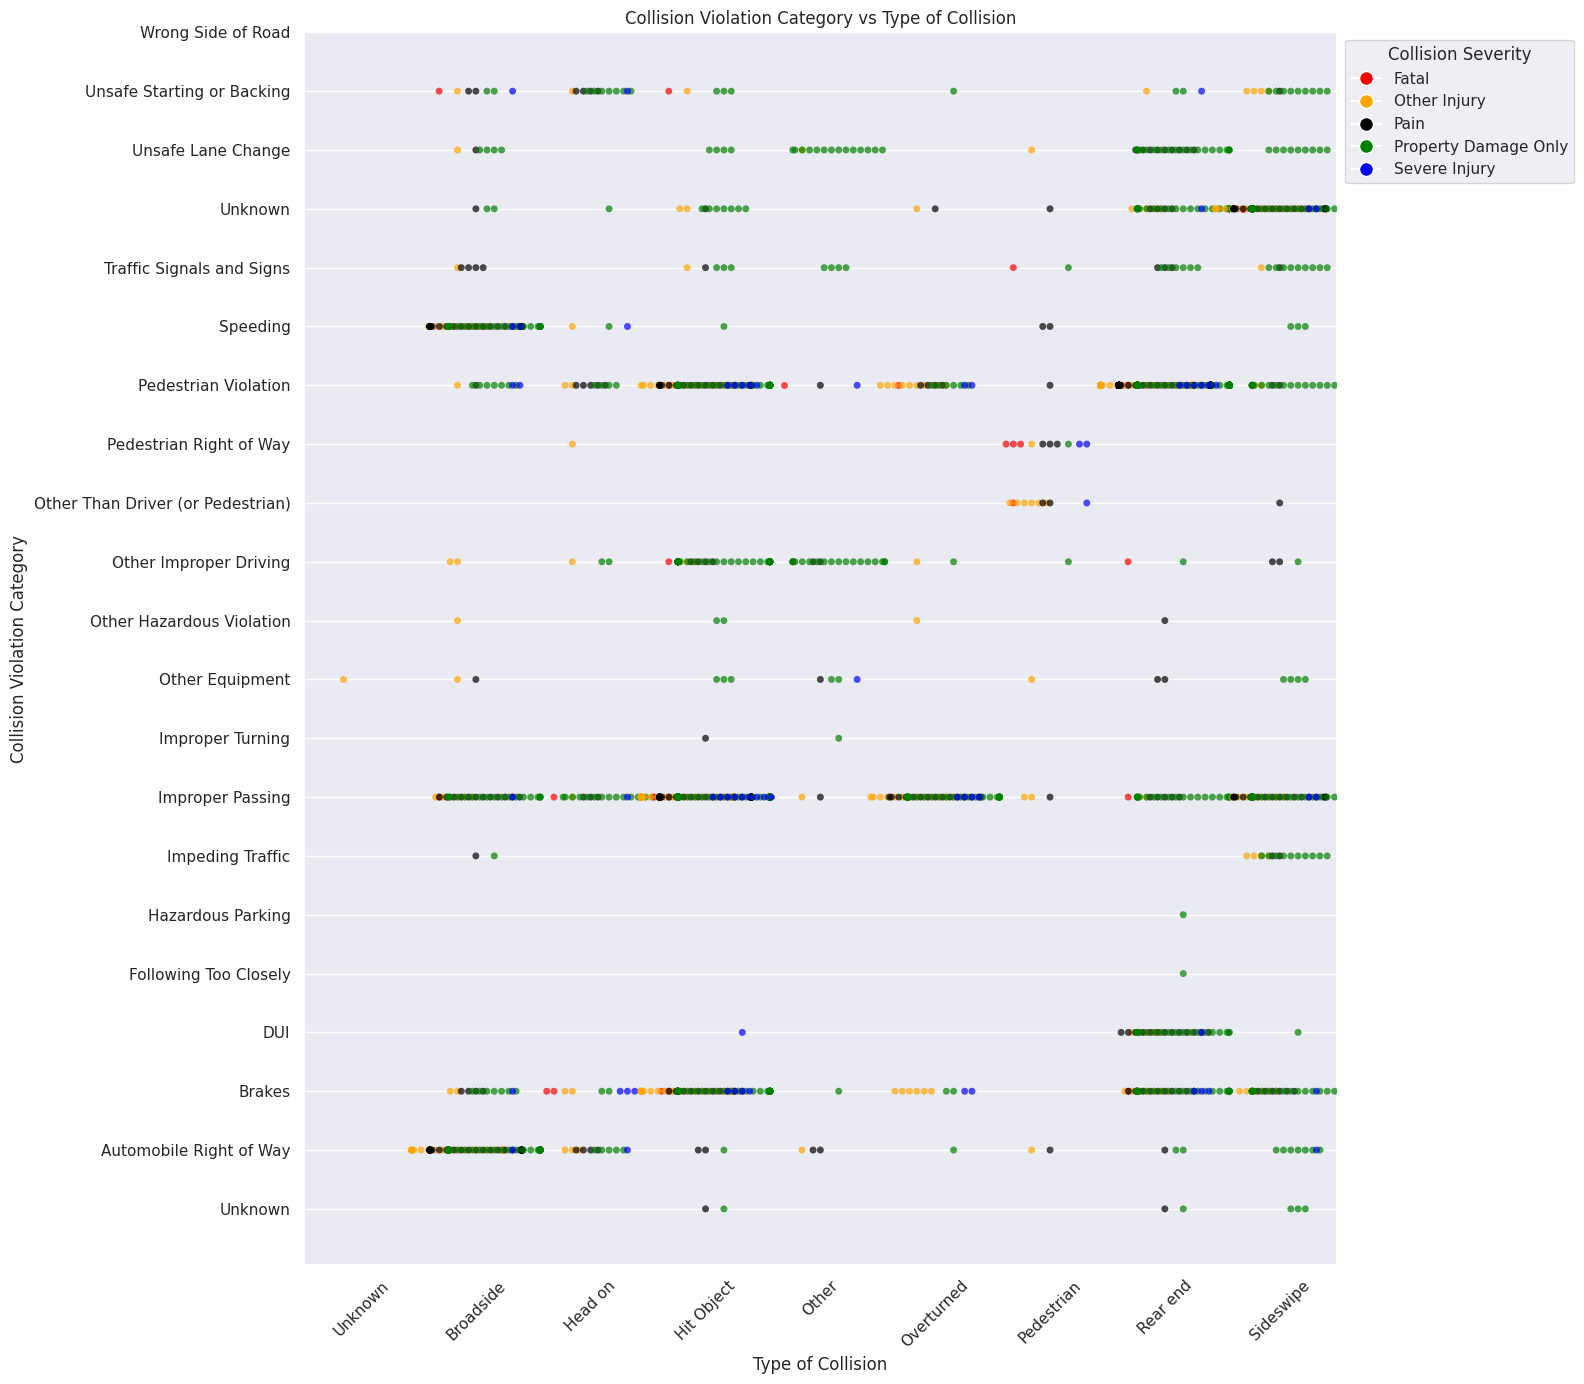

In [ ]:
print(np.sqrt(len(X_train)))
neighbors = np.sqrt(len(X_train))
actual_neighbor = int(neighbors)
print(actual_neighbor)
knn = KNeighborsClassifier(actual_neighbor)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, knn_predictions))
#Prints new KNN accuracy and amount of neighbors after taking smaller subset

palette = {
    0: 'red',
    1: 'orange',
    2: 'black',
    3: 'green',
    4: 'blue'
}
#Manually choose colors for visualization
subset_df['collision_severity'] = subset_df['collision_severity'].astype(int)
#Convert to integer
plt.figure(figsize=(16, 14))

plot1 = sns.swarmplot(
    data=subset_df,
    x='type_of_collision',
    y='pcf_violation_category',
    hue='collision_severity',
    s=5,
    legend=False,
    palette=palette,
    dodge=True,
    alpha=0.7
)#Create plot
original_type_label = ['Unknown','Broadside', 'Head on', 'Hit Object', 'Other', 'Overturned', 'Pedestrian', 'Rear end', 'Sideswipe']
original_pcf_labels = [
    'Unknown',
    'Automobile Right of Way',
    'Brakes',
    'DUI',
    'Following Too Closely',
    'Hazardous Parking',
    'Impeding Traffic',
    'Improper Passing',
    'Improper Turning',
    'Other Equipment',
    'Other Hazardous Violation',
    'Other Improper Driving',
    'Other Than Driver (or Pedestrian)',
    'Pedestrian Right of Way',
    'Pedestrian Violation',
    'Speeding',
    'Traffic Signals and Signs',
    'Unknown',
    'Unsafe Lane Change',
    'Unsafe Starting or Backing',
    'Wrong Side of Road'
]
#Manually make labels for each tick, otherwise I got error
plt.xlabel('Type of Collision')
plt.ylabel('Collision Violation Category')
plt.title('Collision Violation Category vs Type of Collision')

plt.xticks(ticks=range(len(original_type_label)), labels=original_type_label, rotation=45)
plt.yticks(ticks=range(len(original_pcf_labels)), labels=original_pcf_labels)
from matplotlib.lines import Line2D
legend_labels = ['Fatal', 'Other Injury', 'Pain', 'Property Damage Only', 'Severe Injury']
legend_colors = ['red', 'orange', 'black', 'green', 'blue']
#Create colors and make legend
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors]
plt.legend(
    handles=legend_handles,
    labels=legend_labels,
    title='Collision Severity',
    loc='upper left',
    bbox_to_anchor=(1, 1)
)#Use bbox so that the legend appears outside the graph
plt.tight_layout()
plt.show()
#KNN with reducing size for visualization purposes

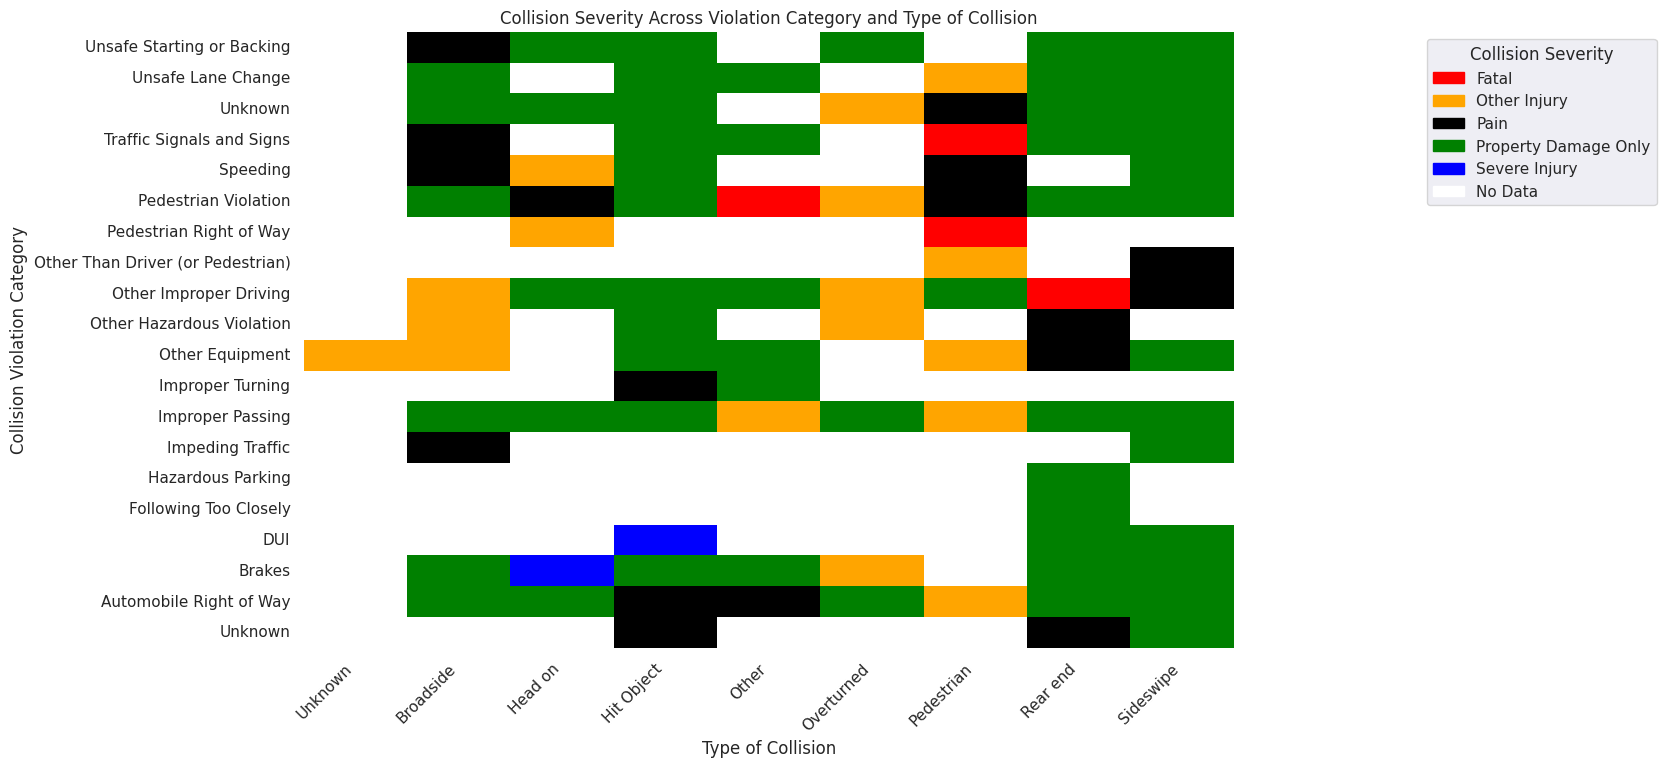

In [ ]:
most_frequent_severity = subset_df.groupby(['type_of_collision', 'pcf_violation_category'])['collision_severity'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).reset_index()
#groups data and calculates for majority label
# fill in unknown values with '5'
heatmap_data = most_frequent_severity.pivot(index='pcf_violation_category', columns='type_of_collision', values='collision_severity').fillna(5)
heatmap_data = heatmap_data.iloc[::-1]
#Converts dataframe to matrix
#Mapping each subcategory within feature to a number
label_mappings = {
    'pcf_violation_category':  {
    0: 'Unknown',
    1: 'Automobile Right of Way',
    2: 'Brakes',
    3: 'DUI',
    4: 'Following Too Closely',
    5: 'Hazardous Parking',
    6: 'Impeding Traffic',
    7: 'Improper Passing',
    8: 'Improper Turning',
    9: 'Other Equipment',
    10: 'Other Hazardous Violation',
    11: 'Other Improper Driving',
    12: 'Other Than Driver (or Pedestrian)',
    13: 'Pedestrian Right of Way',
    14: 'Pedestrian Violation',
    15: 'Speeding',
    16: 'Traffic Signals and Signs',
    17: 'Unknown',
    18: 'Unsafe Lane Change',
    19: 'Unsafe Starting or Backing',
    20: 'Wrong Side of Road'
}}


row_labels = [label_mappings['pcf_violation_category'].get(idx, 'Unknown') for idx in heatmap_data.index]
#Converts numeric rows to labels
plt.figure(figsize=(12, 8))

palette = {
    0: 'red',     # Fatal
    1: 'orange',  # Other Injury
    2: 'black',  # Pain
    3: 'green',   # Property Damage Only
    4: 'blue',     # Severe Injury
    5: 'white'    # NA
}

cmap = sns.mpl.colors.ListedColormap(palette.values())
#Maps colors
boundaries = [-1.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]#Boundaries for correct coloring
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

ax = sns.heatmap(heatmap_data, annot=False, cmap=cmap, fmt='g', cbar=False, norm=norm)
#Makes heatmap using colors

original_type_label = ['Unknown','Broadside', 'Head on', 'Hit Object', 'Other', 'Overturned', 'Pedestrian', 'Rear end', 'Sideswipe']
#Labels for type of collision
ax.set_xticklabels(original_type_label, rotation=45, ha='right')
ax.set_yticklabels(row_labels,rotation=0)
#Labeling ticks
plt.xlabel('Type of Collision')
plt.ylabel('Collision Violation Category')
plt.title('Collision Severity Across Violation Category and Type of Collision')
#Plot label
legend_labels = ['Fatal', 'Other Injury', 'Pain', 'Property Damage Only', 'Severe Injury', 'No Data']
legend_colors = ['red', 'orange', 'black', 'green', 'blue', 'white']
legend_handles = [plt.Rectangle((0,0),1,1, color=color) for color in legend_colors]
#uses colored rectangles so easier to visualize
plt.legend(legend_handles, legend_labels, title='Collision Severity', loc='upper left', bbox_to_anchor=(1.2,1))
#Manually make legend using same process as before
plt.show()

In [ ]:
from autogluon.tabular import TabularPredictor

In [ ]:
from autogluon.tabular import TabularPredictor

# Recombine training data into a single DataFrame
train_data = pd.concat([X_train, y_train], axis=1)


# Train the model
predictor = TabularPredictor(label=dependent_feature).fit(train_data, time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20250610_001533"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       7.58 GB / 12.67 GB (59.8%)
Disk Space Avail:   9.24 GB / 15.00 GB (61.6%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	p

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, confusion_matrix
)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Full classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy:  0.6437
Precision: 0.6224
Recall:    0.6437
F1 Score:  0.5566

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.50      0.21      0.29        58
           2       0.55      0.09      0.16       130
           3       0.65      0.97      0.78       330
           4       1.00      0.07      0.13        14

    accuracy                           0.64       536
   macro avg       0.74      0.32      0.35       536
weighted avg       0.62      0.64      0.56       536

Confusion Matrix:
[[  1   1   0   2   0]
 [  0  12   1  45   0]
 [  0   4  12 114   0]
 [  0   3   8 319   0]
 [  0   4   1   8   1]]
